# Tracking results analysis

This notebook is the last to be executed in order to analyse the data from the tracking.

**Use the environment "myenv" for this notebook"**

To do this, import the myenv.yml file into your Home directory. Open it and change the prefix /rds/general/user/ecd24/home/anaconda3/envs/myenv to your own (usually, you just need to change ecd24 to your username). Open a terminal and execute the command 'conda env create -f myenv.yml'.

In this example, the zebrafish heart was captured by a light sheet fluorescent microscope with a frequency of 150 im/sec on 201 slices. This microscope stopped at each slice and captured 1 second of images. The z-movies have been imported in my home directory can be found in the folder called 'Z-slices'.

## The basic procedures : 

A - Movement of labels over time 

B - Trajectories of the nuclei

C - Relative distances over time

D - Speed over time 

E - Calculation of Volume, Surface Area, and Convex Hull Area

F - Volume over time

G - Solidity over time (V/Vconv) 

H - SA:V ratio over time

I - Sphericity over time

**Note: Sometimes, the error `TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'` appears for a reason I cannot explain. In that case, you have no choice but to restart the kernel and rerun the programs.**

# nuclei coords


To understand the segment coordinates and real coordinates generated by the 3DeeCellTracker notebooks and what happens when swiching from segment coordinates to real coordinates:

The coordinates (real or segment) are displayed as follows: (y, x, z).
We open `coord_seg_1 = worm1/seg/coords000001.npy` and look for the line in `coord_real_1 = worm1/track_results/coords_real/coords000001.npy` that has coordinates closest to [144 108 70] (the first line of `coord_seg_1`). We find [143.62452698 108.24022675  70.21116638].

We do 2 things:

1) We search for the label of [144 108 70] in ImageJ and find it is label 104.

2) We search in `coord_real_1` for the line number where we find the point [143.62452698 108.24022675  70.21116638], and discover it is the line n°103 (and not 104 because indice starts at 0).

Then, we look for line number 103 in `coord_real_2 = worm1/track_results/coords_real/coords000002.npy`. The obtained coordinates are [144.57585144 108.23757935  70.40181732], which is very close to [143.62452698 108.24022675  70.21116638], so it is certainly the same nucleus.

To confirm this hypothesis, we look for similar coordinates in `coord_seg_2 = worm1/seg/coords000002.npy` and find [145 108  70]. We search for the label of [145 108  70] in ImageJ and find it is 104.

**Therefore, each `coord_real` file displays the nuclei in order according to the value of the labels at each time step.**

Note: The offset of 1 between the label value and the line number of the associated coordinates is because the labeling numbers start at 1 (label "0" is th background), while Python counts lines starting from index 0.

You can try it with other lines of coord_seg_i etc etc

(This example has been done on the z-movies aligned without LoG processing)

In [7]:
import numpy as np

# coord_real_1 = "worm1/track_results/coords_real/coords000001.npy"

# visual_real = np.load(coord_real)

# print(visual_real)

# print(visual_real.shape)

# # 2) We search in `coord_real_1` for the line number where we find the point [143.62452698 108.24022675  70.21116638], and discover it is 103

# s = 0
# for i in range(visual_real.shape[0]):
#     print(visual_real[i,0])
#     if visual_real[i,0]!=143.62452697753906 : 
#         s+=1
#     else:
#         break
# print("position of coord 143.62452697753906:", s) #we find 103


# print("the coordinates at line 103 are :", visual_real[103,0]) # [144.57585144 108.23757935  70.40181732]



# print(type(visual_real))
# coord_seg = "worm1/seg/coords000002.npy"

# visual_seg = np.load(coord_seg)

# print(visual_seg)

# print(visual_seg.shape)

# Import Packages

In [1]:
import imageio as io 
from skimage.measure import label
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import random
import os
from scipy.signal import savgol_filter
from scipy.stats import shapiro, anderson, kstest, norm
import pandas as pd
from skimage.measure import regionprops
import time

# Initialisations

Note, the first dimension of the image should be the time (n°images), the second should be the number of slices, the third should be the height of each image, and the fourth should be the width. Verify the order with the cell below (in the given example, the dimensions are correct).

In [6]:
image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')
print(image.shape)

/var/tmp/pbs.9789540.pbs/ipykernel_150970/1938315741.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')


(92, 201, 320, 300)


In [2]:
#real voxel size
voxel_size= (0.729, 0.729, 1.26) # x y and z sizes of the voxel in micron

#number of labels
image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')
image_1d = np.ravel(image)

# Count unique values
unique_values = np.unique(image_1d)
num_points = len(unique_values) - 1

delta = 1/(150)*1000

# Path to the directory containing the files
directory = 'worm1/track_results/coords_real/'
files = [f for f in os.listdir(directory) if f.startswith('coords') and f.endswith('.npy')]
num_files = len(files)

# Load all data at once
data = [np.load(os.path.join(directory, f'coords{j:06}.npy')) for j in range(num_files)]

# Another way to count the number of points
num_points = data[0].shape[0]
print(f"num_points:",num_points)

/var/tmp/pbs.9807721.pbs/ipykernel_3231640/418385078.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread('labeled3D_with_time_image_LoG_ffn_worm3.ome.tif')


num_points: 310


# A - Movement of labels over time 

- ## Each label in different color

In [33]:
pio.renderers.default = 'notebook'

# Function to generate a unique random color
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize a set to track used colors
used_colors = set()

# Generate a color for each label
colors = [random_color(used_colors) for _ in range(num_points)]

fig = go.Figure()

initial_data = data[0]
for label in range(num_points):
        fig.add_trace(go.Scatter3d(
            x=[initial_data[label, 0]],
            y=[initial_data[label, 1]],
            z=[initial_data[label, 2]],
            mode='markers',
            marker=dict(size=5, color=colors[label]),
            name=f'Label {label + 1}'
        ))

# Create frames for the animation, excluding those from the Atrium list at each step
frames = []
for j in range(num_files):
    frame_data = data[j]
    frame = go.Frame(data=[
        go.Scatter3d(
            x=[frame_data[label, 0]],
            y=[frame_data[label, 1]],
            z=[frame_data[label, 2]],
            mode='markers',
            marker=dict(size=5, color=colors[label]),
            name=f'Label {label + 1}',
            showlegend=True
        ) for label in range(num_points)
    ], name=f'Time {j}')
    frames.append(frame)

# Add the frames to the figure
fig.frames = frames

# Configure the axes and background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
        bgcolor='white'
    ),
    width=800,
    margin=dict(r=20, b=10, l=10, t=10),
    legend=dict(
        title='Labels',
        itemsizing='constant'
    ),
    sliders=[{
        'steps': [{'args': [[f.name], {'frame': {'duration': 0, 'redraw': True},
                                       'mode': 'immediate', 'transition': {'duration': 0}}],
                   'label': f'Time {i}',
                   'method': 'animate'} for i, f in enumerate(fig.frames)],
        'transition': {'duration': 0},
        'x': 0.1,
        'xanchor': 'left',
        'y': 0,
        'yanchor': 'top',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Time:',
            'visible': True,
            'xanchor': 'right'
        },
        'len': 0.9
    }]
)

# Display the figure with the 'iframe' renderer
fig.show(renderer="iframe")

- ## Classify the labels

Create the following lists: Ventricle, Atrium, Sinus_Venosus, Not_identified_yet, Out, and plot the graph below to observe the unclassified labels and continue filling the lists. The "Out" list would consist of labels with incorrect trajectories (incoherent movement) making them impossible to consider in the calculations (speed, volume, solidity...). The Not_identified_yet list would consist of labels that have not yet been classified and need to be.

In [3]:
# Classes :
# Red
Ventricle = [138,149,151,152,153,156,157,158,159,162,163,164,165,166,171,173,175,176,178,179,180,184,186,187,188,189,192,193,194,195,196,197,198,199,201,202,203,204,205,206,207,209,210,211,212,214,215,216,217,218,219,221,222,223,224,225,227,228,231,232,233,234,238,239,240,242,245,246,247,248,250,252,253,255,257,258,259,260,261,262,263,265,266,267,271,272,273,275,276,277,281,282,284,285,286,287,292,296]

# Magenta
Atrium = [15,20,23,24,25,26,27,29,30,31,32,36,37,39,40,42,43,45,46,47,49,50,51,52,55,57,58,59,61,62,63,68,70,71,72,73,74,75,77,78,79,80,81,82,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,104,105,106,107,108,111,112,113,115,118,119,120,122,123,124,125,126,127,128,130,132,134,135,136,137,139,140,142,143,144,146,147,148,160,167]

# Cyan
Sinus_Venosus = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,21,22,28,33,34,35,38,41,44,48,53,54,56,60,64,65,66,67,69,76,83,101,103,114,116,117,121,129,131,133,145,150,155,161,168,169,174,177,181,182,183,190,191,200,208,213,220,226,229,230,235,236,237,243,241,244,249,251,254,256,264,268,269,270,274,278,279,280,283,288,289,290,291,293,294,295,297,298,299,300,301,302,303,304,305,306,307,308,309,310]

# Yellow
Out = [109,110,141,154,172,170,185]

# Gray
Not_identified_yet =  [i for i in range (1,num_points+1)  if i not in Atrium and i not in Ventricle and i not in Sinus_Venosus and i not in Out]

In [35]:
# Set the default renderer
pio.renderers.default = 'notebook'


# Define specific colors for each category
colors_dict = {
    'Ventricle': 'rgba(255, 0, 0, 1)',  # Red
    'Out': 'rgba(255, 255, 0, 1)',  # Yellow
    'Atrium': 'rgba(255, 0, 255, 1)',  # Magenta
    'Sinus_Venosus': 'rgba(0, 255, 255, 1)',  # Cyan
    'Not_identified_yet': 'rgba(128, 128, 128, 1)',  # Gray
}

# Create an empty figure
fig = go.Figure()

# Create a list to store trace data for each frame
frames_data = []

# Add initial traces for each category
for label in range(num_points):
    if label + 1 in Ventricle:
        category = 'Ventricle'
    elif label + 1 in Out:
        category = 'Out'
    elif label + 1 in Atrium:
        category = 'Atrium'
    elif label + 1 in Sinus_Venosus:
        category = 'Sinus_Venosus'
    elif label + 1 in Not_identified_yet:
        category = 'Not_identified_yet'
    
    frames_data.append({
        'x': [data[0][label, 0]],
        'y': [data[0][label, 1]],
        'z': [data[0][label, 2]],
        'color': colors_dict[category],
        'name': f'Label {label + 1}',
    })

# Add initial traces to the figure
for data_point in frames_data:
    fig.add_trace(go.Scatter3d(
        x=data_point['x'],
        y=data_point['y'],
        z=data_point['z'],
        mode='markers',
        marker=dict(size=5, color=data_point['color']),
        name=data_point['name']
    ))

# Create frames for the animation
frames = []
for j in range(num_files):
    frame_data = data[j]
    frame = go.Frame(data=[
        go.Scatter3d(
            x=[frame_data[label, 0]],
            y=[frame_data[label, 1]],
            z=[frame_data[label, 2]],
            mode='markers',
            marker=dict(size=5, color=frames_data[label]['color']),
            name=frames_data[label]['name'],
            showlegend=True
        ) for label in range(num_points)
    ], name=f'Time {j}')
    frames.append(frame)

# Add the frames to the figure
fig.frames = frames

# Configure the axes and background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
        bgcolor='white'
    ),
    width=800,
    margin=dict(r=20, b=10, l=10, t=10),
    legend=dict(
        title='Labels',
        itemsizing='constant'
    ),
    sliders=[{
        'steps': [{'args': [[f.name], {'frame': {'duration': 0, 'redraw': True},
                                       'mode': 'immediate', 'transition': {'duration': 0}}],
                   'label': f'Time {i}',
                   'method': 'animate'} for i, f in enumerate(fig.frames)],
        'transition': {'duration': 0},
        'x': 0.1,
        'xanchor': 'left',
        'y': 0,
        'yanchor': 'top',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Time:',
            'visible': True,
            'xanchor': 'right'
        },
        'len': 0.9
    }]
)

fig.show(renderer="iframe")


Ensure that no label is common to two lists using the following program before proceeding. If nothing is displayed when running this program, then no labels have been selected twice.

In [6]:
# Convert lists to sets for easier intersection
sets_dict = {
    "Ventricle": set(Ventricle),
    "Atrium": set(Atrium),
    "Sinus_Venosus": set(Sinus_Venosus),
    "Out": set(Out),
    "Not_identified_yet": set(Not_identified_yet),
}

# Function to find common elements between each pair of sets
def find_common_between_pairs(sets_dict):
    common_in_pairs = {}
    list_names = list(sets_dict.keys())
    for i in range(len(list_names)):
        for j in range(i + 1, len(list_names)):
            set1_name = list_names[i]
            set2_name = list_names[j]
            common_elements = sets_dict[set1_name].intersection(sets_dict[set2_name])
            for element in common_elements:
                if element not in common_in_pairs:
                    common_in_pairs[element] = []
                common_in_pairs[element].append((set1_name, set2_name))
    return common_in_pairs

# Find common elements between each pair of sets
common_in_pairs = find_common_between_pairs(sets_dict)

# Display the results
for element, list_pairs in common_in_pairs.items():
    pair_names = [f"{pair[0]} and {pair[1]}" for pair in list_pairs]
    print(f"Element {element} is found in the list pairs: {', '.join(pair_names)}")


# B - Trajectories of the nuclei

In [36]:
# Set the default renderer
pio.renderers.default = 'notebook'

# Function to generate a unique random color
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color
        

# Initialize the figure
fig = go.Figure()

# Initialize a set to track used colors
used_colors = set()

# Add trajectories for each point
for label in range(1, num_points + 1): 
    x = [data[j][label - 1, 0] for j in range(num_files)]
    y = [data[j][label - 1, 1] for j in range(num_files)]
    z = [data[j][label - 1, 2] for j in range(num_files)]
    
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        name=f'label {label}', 
        line=dict(width=2, color=random_color(used_colors)),
    ))

# Configure the axes and background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
        bgcolor='white'
    ),
    width=800,
    margin=dict(r=20, b=10, l=10, t=10)
)

fig.show(renderer="iframe")


# C - Relative distances over time

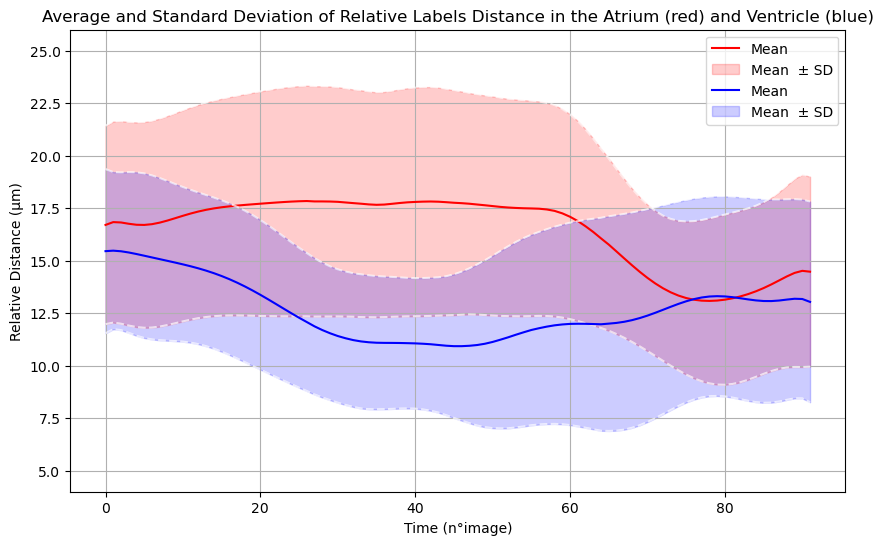

In [8]:
relative_distance_3_closest_neighbours_dict = {}

# Create a KD tree with the generated points. The tree is a data structure
# used to organize points in a k-dimensional space.

# Query the tree to find the 3 nearest neighbors of the first point (data[label - 1]).
# The query method returns the distances and indices of the nearest neighbors.

for label in range(1, num_points + 1):
    relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] =[]
    for j in range(num_files):  
        data = np.load(f'worm1/track_results/coords_real/coords{j:06}.npy')
        tree = KDTree(data)
        dist, ind = tree.query(data[label - 1], k=4) 
        ind = ind[ind != label-1]
        dist = dist[dist != 0]
        mean_with_3_closest_neighbours = (dist[0]+dist[1]+dist[2])/3
        relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'].append(mean_with_3_closest_neighbours)

# ATRIUM 

mean_relative_distance_in_Atrium = np.mean([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Atrium], axis=0)
SD_relative_distance_in_Atrium = np.std([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Atrium], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_relative_distance_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_relative_distance_in_Atrium + SD_relative_distance_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_relative_distance_in_Atrium - SD_relative_distance_in_Atrium,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_relative_distance_in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_relative_distance_in_Atrium + SD_relative_distance_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_relative_distance_in_Atrium - SD_relative_distance_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_relative_distance_in_Atrium)), mean_relative_distance_in_Atrium + SD_relative_distance_in_Atrium, mean_relative_distance_in_Atrium - SD_relative_distance_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_relative_distance_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_relative_distance_in_Ventricle = np.mean([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Ventricle], axis=0)
SD_relative_distance_in_Ventricle = np.std([relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] for label in Ventricle], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_relative_distance_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_relative_distance_in_Ventricle + SD_relative_distance_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_relative_distance_in_Ventricle - SD_relative_distance_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_relative_distance_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_relative_distance_in_Ventricle + SD_relative_distance_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_relative_distance_in_Ventricle - SD_relative_distance_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_relative_distance_in_Ventricle)), mean_relative_distance_in_Ventricle + SD_relative_distance_in_Atrium, mean_relative_distance_in_Ventricle - SD_relative_distance_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_relative_distance_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# diff = smoothing_mean_Atrium - smoothing_mean_Ventricle
# sign_changes = np.where(np.diff(np.sign(diff)))[0]

# Plot intersection points with annotation
# for idx in sign_changes:
#     plt.plot(idx, smoothing_mean_Atrium[idx], 'go')  # Mark the intersection point with a green dot
#     plt.annotate(f'({idx}, {smoothing_mean_Atrium[idx]:.2f})', xy=(idx, smoothing_mean_Atrium[idx]), xytext=(idx + 5, smoothing_mean_Atrium[idx] + 0.1),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')
    
# Find the index of the lowest point of the smoothed curve for the Atrium
# min_idx = np.argmin(smoothing_mean_Atrium)

# Annotate the lowest point of the smoothed curve for the Atrium
# plt.annotate(f'Minimum\n({min_idx}, {smoothing_mean_Atrium[min_idx]:.2f})', xy=(min_idx, smoothing_mean_Atrium[min_idx]), xytext=(min_idx + 10, smoothing_mean_Atrium[min_idx] + 0.5),
#              arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')


# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Relative Distance (µm)')
plt.title('Average and Standard Deviation of Relative Labels Distance in the Atrium (red) and Ventricle (blue)')
plt.legend()

plt.ylim(4, 26)


# Display the plot
plt.show()


#for checking :

# for label in range(9,10):
#     relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'] =[]
#     for j in range(num_files):  
#         data = np.load(f'worm1/track_results/coords_real/coords{j:06}.npy')
#         print(data[label - 1])
#         tree = KDTree(data)
#         dist, ind = tree.query(data[label - 1], k=4) 
#         ind = ind[ind != label-1]
#         print(data[ind[0]])
#         dist = dist[dist != 0]
#         print(dist)
#         print(ind)
#         mean_with_3_closest_neighbours = (dist[0]+dist[1]+dist[2])/3
#         print(mean_with_3_closest_neighbours)
#         relative_distance_3_closest_neighbours_dict[f'relative_distance_{label}'].append(mean_with_3_closest_neighbours)

# 1rst result of the program :
# [ 24.64923286 154.78797913 166.39253235]
# [ 32.15504837 157.43518066 129.6085968 ]
# [37.63512796 50.45248572 52.13685436]
# [15 47  0]
# 46.74148934936907

# manual check with ind = 15
# print(np.sqrt(( 24.64923286 -32.15504837)**2  +(154.78797913- 157.43518066 )**2  +(166.39253235-129.6085968 )**2))  
# 37.63512796520222

#

# D - Speed of the labelled nuclei over time

-  ## Speed norm over time (x=t,y=V) for each label and speed trajectories over time (x=Vx,y=Vy,z=Vz)

choose your label for the speed norm in the program (here you have label = 97)

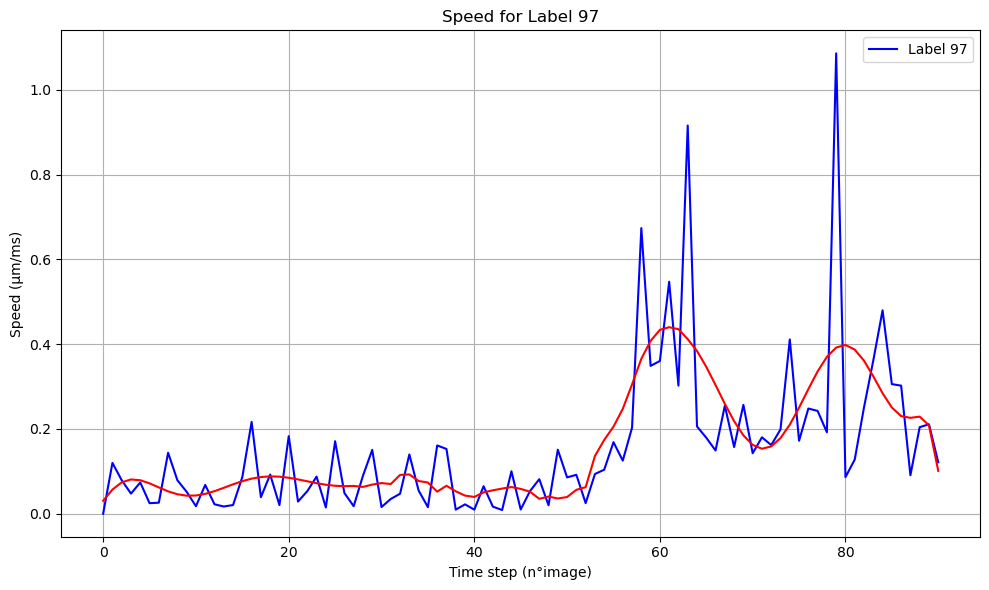

In [50]:
# Set the default renderer
pio.renderers.default = 'notebook'

norm_velocity_dict = {}

# Function to generate a unique random color for Plotly
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color
        
# New function to generate a random color in hexadecimal format for Matplotlib
def random_color_hex(existing_colors):
    while True:
        r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        color = "#{:02x}{:02x}{:02x}".format(r, g, b)
        if color not in existing_colors:
            existing_colors.add(color)
            return color
        

# Initialize the figure
fig = go.Figure()


# Initialize a set to track used colors
used_colors = set()

data = [np.load(os.path.join(directory, f'coords{j:06}.npy')) for j in range(num_files)]


# Add trajectories for each point
for label in range(1, num_points + 1): 
    Vx = np.array([(data[j+1][label - 1, 1] - data[j][label - 1, 1])/delta for j in range(num_files-1)])
    Vy = np.array([(data[j+1][label - 1, 0] - data[j][label - 1, 0])/delta for j in range(num_files-1)])
    Vz = np.array([(data[j+1][label - 1, 2] - data[j][label - 1, 2])/delta for j in range(num_files-1)])
    V = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    norm_velocity_dict[f'velocity_label_{label}']=V
#     print(V)
    
    fig.add_trace(go.Scatter3d(
        x=Vx,
        y=Vy,
        z=Vz,
        mode='lines',
        name=f'label {label}', 
        line=dict(width=2, color=random_color(used_colors)),
    ))
    
    
# Configure the axes and background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
        bgcolor='white'
    ),
    width=800,
    margin=dict(r=20, b=10, l=10, t=10)
)

label = 97

# Matplotlib plot for the norm of the speed of the specific label
plt.figure(figsize=(10, 6))
plt.plot(range(num_files - 1), norm_velocity_dict[f'velocity_label_{label}'], label=f'Label {label}', color="blue")

# #interpolation

# x = np.linspace(min(range(num_files - 1)), max(range(num_files - 1)), num=182)
# norm_velocity_interpolated = barycentric_interpolate(range(num_files - 1), norm_velocity_dict[f'velocity_label_{label}'], x)

# from scipy.interpolate import interp1d

# Interpolation avec interp1d
#x = np.linspace(min(range(num_files - 1)), max(range(num_files - 1)), num=1000)
# f_interpolated = interp1d(range(num_files - 1), norm_velocity_dict[f'velocity_label_{label}'], kind='cubic')
# norm_velocity_interpolated = f_interpolated(x)



fin_lin = savgol_filter(norm_velocity_dict[f'velocity_label_{label}'],55,10)

plt.plot(range(num_files - 1),fin_lin, color="red")


# plt.plot(x, norm_velocity_interpolated, label=f'Label interpolated {label}', color=f'#{random.randint(0, 0xFFFFFF):06x}')
plt.xlabel('Time step (n°image)')
plt.ylabel('Speed (µm/ms)')
plt.title(f'Speed for Label {label}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Display the figure with the 'iframe' renderer
fig.show(renderer="iframe")




- ## Average speed with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole)

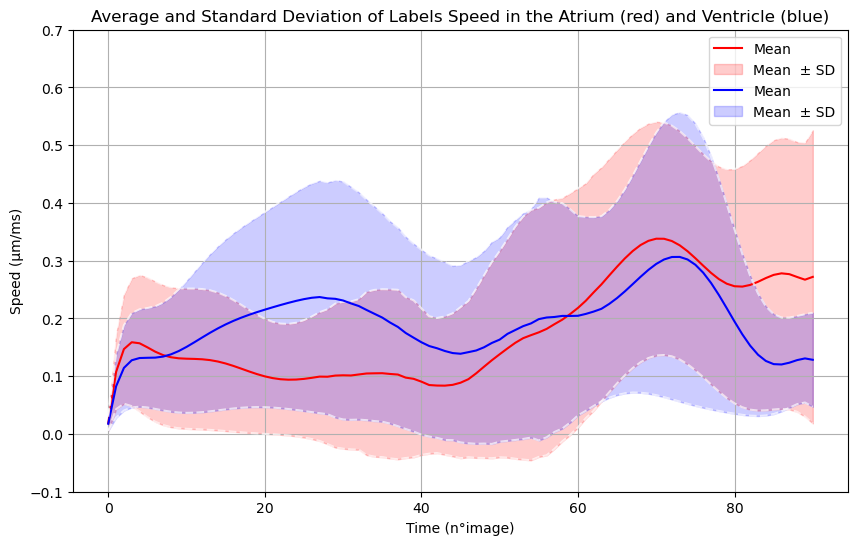

In [51]:
# Set the default renderer
pio.renderers.default = 'notebook'

norm_velocity_dict = {}

# New function to generate a random color in hexadecimal format for Matplotlib
def random_color_hex(existing_colors):
    while True:
        r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        color = "#{:02x}{:02x}{:02x}".format(r, g, b)
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize the figure
fig = go.Figure()


# Initialize a set to track used colors
used_colors = set()

# Add trajectories for each point
for label in range(1, num_points + 1):  
    Vx = np.array([(data[j+1][label - 1, 1] - data[j][label - 1, 1])/delta for j in range(num_files-1)])
    Vy = np.array([(data[j+1][label - 1, 0] - data[j][label - 1, 0])/delta for j in range(num_files-1)])
    Vz = np.array([(data[j+1][label - 1, 2] - data[j][label - 1, 2])/delta for j in range(num_files-1)])
    V = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    norm_velocity_dict[f'velocity_label_{label}']=V


# ATRIUM 

mean_velocity_in_Atrium = np.mean([norm_velocity_dict[f'velocity_label_{label}'] for label in Atrium], axis=0)
SD_velocity_in_Atrium = np.std([norm_velocity_dict[f'velocity_label_{label}'] for label in Atrium], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_velocity_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_velocity_in_Atrium + SD_velocity_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_velocity_in_Atrium - SD_velocity_in_Atrium,55,10)

# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_velocity_in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_velocity_in_Atrium + SD_velocity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_velocity_in_Atrium - SD_velocity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_velocity_in_Atrium)), mean_velocity_in_Atrium + SD_velocity_in_Atrium, mean_velocity_in_Atrium - SD_velocity_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_velocity_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_velocity_in_Ventricle = np.mean([norm_velocity_dict[f'velocity_label_{label}'] for label in Ventricle], axis=0)
SD_velocity_in_Ventricle = np.std([norm_velocity_dict[f'velocity_label_{label}'] for label in Ventricle], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_velocity_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_velocity_in_Ventricle + SD_velocity_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_velocity_in_Ventricle - SD_velocity_in_Ventricle,55,10)


# Plot the mean
#plt.plot(mean_velocity_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_velocity_in_Ventricle + SD_velocity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD 
#plt.plot(mean_velocity_in_Ventricle - SD_velocity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_velocity_in_Ventricle)), mean_velocity_in_Ventricle + SD_velocity_in_Atrium, mean_velocity_in_Ventricle - SD_velocity_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_velocity_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Speed (µm/ms)')
plt.title('Average and Standard Deviation of Labels Speed in the Atrium (red) and Ventricle (blue)')
plt.legend()

plt.ylim(-0.1, 0.7)

# Display the plot
plt.show()


-  ## Comparing the speed trajectories (x=Vx,y=Vy,z=Vz) with a sphere  

change the radius of the sphere

In [38]:
radius = 1 # Choose the radius

In [39]:
# Set the default renderer
pio.renderers.default = 'notebook'

norm_velocity_dict = {}

# Function to generate a unique random color for Plotly
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize the figure
fig = go.Figure()

# Initialize a set to track used colors
used_colors = set()

# Function to generate the coordinates of a sphere with a specified radius
def sphere_coordinates(radius, num_points=300):
    phi = np.linspace(0, np.pi, num_points//2)
    theta = np.linspace(0, 2*np.pi, num_points)
    phi, theta = np.meshgrid(phi, theta)
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return x, y, z

# Coordinates of the sphere with a radius of 1 (ajustable)
x_sphere, y_sphere, z_sphere = sphere_coordinates(radius)

# Add the sphere to the figure
fig.add_trace(go.Mesh3d(
    x=x_sphere.flatten(),
    y=y_sphere.flatten(),
    z=z_sphere.flatten(),
    opacity=0.3,  # Opacité de la sphère
    color='blue',  # Couleur de la sphère
    name=f'Sphere (Radius {radius})',
))

# List to store indices of labels whose trajectory goes outside the sphere
labels_outside_sphere = []

# Add trajectories for each point
for label in range(1, num_points + 1): 
    Vx = np.array([(data[j+1][label - 1, 1] - data[j][label - 1, 1])/delta for j in range(num_files-1)])
    Vy = np.array([(data[j+1][label - 1, 0] - data[j][label - 1, 0])/delta for j in range(num_files-1)])
    Vz = np.array([(data[j+1][label - 1, 2] - data[j][label - 1, 2])/delta for j in range(num_files-1)])
    
    # Check if the trajectory goes outside the sphere
    distances = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    if np.any(distances > radius):
        labels_outside_sphere.append(label)
        
        fig.add_trace(go.Scatter3d(
            x=Vx,
            y=Vy,
            z=Vz,
            mode='lines',
            name=f'label {label}', 
            line=dict(width=2, color=random_color(used_colors)),
        ))
    
# Configure the axes and background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
        bgcolor='white'
    ),
    width=800,
    margin=dict(r=20, b=10, l=10, t=10)
)

# Display the figure with the 'iframe' renderer
fig.show(renderer="iframe")


- ## Trajectory of the nuclei with a speed longer than the radius of the sphere

In [41]:
# Function to generate a unique random color for Plotly
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize used colors and random colors
used_colors = set()
list_random_color = [random_color(used_colors) for _ in range(len(labels_outside_sphere))]

# Create a new figure for the trajectories that go outside the sphere
fig_outside_sphere = go.Figure()

print(f'Labels whose speed curve exits the sphere : {labels_outside_sphere}')

# Add trajectories for each point
for i, label in enumerate(labels_outside_sphere): 
    x = [data[j][label - 1, 0] for j in range(num_files)]
    y = [data[j][label - 1, 1] for j in range(num_files)]
    z = [data[j][label - 1, 2] for j in range(num_files)]
    
    color = list_random_color[i]
    
    fig_outside_sphere.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+markers',
        name=f'label {label}', 
        line=dict(width=2, color=color),
        marker=dict(
            size=[8] + [0] * (num_files - 1),  # Marker size: first point 8, others 0
            color=color, # Marker color is the same as the line color
            symbol='circle',  # Marker symbol
        )
    ))
    

# Configure the axes and background
fig_outside_sphere.update_layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
        bgcolor='white'
    ),
    width=800,
    margin=dict(r=20, b=10, l=10, t=10),
    title='Trajectories of Labels Exiting the Sphere'
)


fig_outside_sphere.show(renderer="iframe")


Labels whose speed curve exits the sphere : [16, 20, 22, 23, 26, 31, 35, 45, 63, 69, 70, 71, 73, 74, 78, 79, 80, 84, 86, 87, 88, 92, 93, 97, 99, 102, 104, 105, 106, 107, 109, 110, 111, 115, 116, 119, 120, 122, 123, 124, 127, 130, 132, 138, 140, 141, 144, 146, 148, 150, 151, 153, 157, 159, 164, 166, 167, 170, 171, 172, 173, 179, 181, 185, 188, 190, 191, 193, 194, 197, 198, 199, 201, 207, 209, 215, 217, 218, 223, 225, 227, 228, 230, 231, 232, 233, 234, 240, 241, 242, 243, 246, 247, 248, 251, 252, 254, 255, 257, 258, 261, 267, 271, 272, 274, 275, 276, 277, 278, 281, 286, 287, 294, 296]


The following program displays the classes of nuclei that have speeds exceeding the radius of the sphere.

In [17]:
# Combine all lists into a dictionary
lists = {'Ventricle': Ventricle, 'Out': Out, 'Atrium': Atrium, 'Sinus_Venosus': Sinus_Venosus, 'labels_outside_sphere': labels_outside_sphere}

# Find common numbers and their corresponding lists
common_numbers = {}

for list_name, lst in lists.items():
    for number in lst:
        if number not in common_numbers:
            common_numbers[number] = {list_name}
        else:
            common_numbers[number].add(list_name)

# Filter numbers that appear in more than one list
common_numbers = {number: list_names for number, list_names in common_numbers.items() if len(list_names) > 1}

# Display the results
if common_numbers:
    for number, list_names in common_numbers.items():
        print(f"The label {number} is found in the lists: {', '.join(list_names)}")
else:
    print("No common numbers")


The label 138 is found in the lists: Ventricle, labels_outside_sphere
The label 151 is found in the lists: Ventricle, labels_outside_sphere
The label 153 is found in the lists: Ventricle, labels_outside_sphere
The label 157 is found in the lists: Ventricle, labels_outside_sphere
The label 159 is found in the lists: Ventricle, labels_outside_sphere
The label 164 is found in the lists: Ventricle, labels_outside_sphere
The label 166 is found in the lists: Ventricle, labels_outside_sphere
The label 171 is found in the lists: Ventricle, labels_outside_sphere
The label 173 is found in the lists: Ventricle, labels_outside_sphere
The label 179 is found in the lists: Ventricle, labels_outside_sphere
The label 188 is found in the lists: Ventricle, labels_outside_sphere
The label 193 is found in the lists: Ventricle, labels_outside_sphere
The label 194 is found in the lists: Ventricle, labels_outside_sphere
The label 197 is found in the lists: Ventricle, labels_outside_sphere
The label 198 is fou

# E - Calculation of Volume, Surface Area, and Convex Hull Area

The calculation of volume is used to plot the curves of volume, SA:V ratio, sphericity, and solidity over time. The calculation of surface area is used to plot sphericity and the SA:V ratio over time, and the calculation of Convex Hull Area is used to plot solidity over time.

## Volume (V)

The second method is faster, so it was used for the plots.

-  ## 1st method 

In [21]:
start_time = time.time()

volume_px_dict = {}

# Count the number of unique values
unique_values = np.unique(image_1d)

# Display the number of unique values
# print("The number of different pixel values in the image is:", len(unique_values))

# Iterate over the second dimension (t values from 0 to 91)
for t in range(image.shape[0]):
    # Access the data for the current t value
    slices_at_t = image[:, t, :, :]
    volume_px_dict[f'vol_pix_at_t={t}'] = []
    for i in range(1,len(unique_values)):
        volume=np.count_nonzero(slices_at_t == i)
        volume_px_dict[f'vol_pix_at_t={t}'].append(volume)

end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")


Execution time: 237.62348175048828 secondes


-  ## 2nd method 

In [4]:
from skimage import io

start_time = time.time()

volume_px_dict = {}

for t in range(image.shape[0]): 
    # Access the data for the current t value
    slices_at_t = image[:, t, :, :]
    properties = regionprops(slices_at_t)
    volume_px_dict[f'vol_pix_at_t={t}'] = []
    for prop in properties:
        volume_px_dict[f'vol_pix_at_t={t}'].append((prop.label,(prop.area)*voxel_size[0]*voxel_size[1]*voxel_size[2]))
        x,y = zip(*volume_px_dict[f'vol_pix_at_t={t}'])
    for i in range(1,num_points+1):
        if i not in x :
            volume_px_dict[f'vol_pix_at_t={t}'].insert(i-1,(i,None))
    

end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")
    


Execution time: 2.5083816051483154 secondes


## Surface Area (SA)

In [ ]:
from skimage import io

start_time = time.time()

surface_px_dict = {}

new_surface_px_dict = {} 

surface_element_dict = {}

surface_area_label_dict = {}


array_3d = np.array([
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]], # z=0
    [[0, 1, 0], [1, 1, 1], [0, 1, 0]], # z=1
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]] # z=2
])

m_depth, m_height, m_width = array_3d.shape
print(array_3d.shape)


# Iterate over the second dimension
for t in range(image.shape[0]):
# for t in range(22,25):
    # Access the data for the current t value
    slices_at_t = image[t, :, :, :]
    # Count the number of unique values
    unique_values = np.unique(slices_at_t)
    unique_values = np.delete(unique_values, 0)
    # Display the number of unique values
    print("The number of different pixel values in the image is:", len(unique_values))
    # Initialize surface_element_dict with all possible keys
    for value in unique_values:
        surface_element_dict[value] = 0
    
    surface_px_dict[f'surf_pix_at_t={t}'] = []
    
    for z in range(1, slices_at_t.shape[0] - m_depth + 1):
        for y in range(1, slices_at_t.shape[1] - m_height + 1):
            for x in range(1, slices_at_t.shape[2] - m_width + 1):
            
                # Perform element-wise multiplication
                element_wise_product = slices_at_t[z:z+m_depth, y:y+m_height, x:x+m_width] * array_3d
                # Define the value of the central pixel 
                px = element_wise_product[1, 1, 1] # central pixel is at position [1, 1, 1] instead of [2, 2, 2] because position start at 0, not 1.
                if px != 0 and np.count_nonzero(element_wise_product == px) > 1 and np.count_nonzero(element_wise_product != px) > 20: # if central pixel different to 0, and at least one neighbouring pixel is equal to the central pixel and another is different to the central pixel 
                    if element_wise_product[0, 1, 1] !=px : # element_wise_product[z = 0, y = 1, x = 1] 
                        surface_element_dict[px] += voxel_size[0]*voxel_size[1] # x*y is an external face of the voxel
                    if element_wise_product[2, 1, 1] !=px :
                        surface_element_dict[px] += voxel_size[0]*voxel_size[1] # x*y is an external face of the voxel
                    if element_wise_product[1, 1, 0] !=px :
                        surface_element_dict[px] += voxel_size[2]*voxel_size[1] # z*y is an external face of the voxel
                    if element_wise_product[1, 1, 2] !=px :
                        surface_element_dict[px] += voxel_size[2]*voxel_size[1] # z*y is an external face of the voxel
                    if element_wise_product[1, 0, 1] !=px :
                        surface_element_dict[px] += voxel_size[2]*voxel_size[0] # z*x is an external face of the voxel
                    if element_wise_product[1, 2, 1] !=px :
                        surface_element_dict[px] += voxel_size[2]*voxel_size[0] # z*x is an external face of the voxel
                else : 
                    pass
                        
    
    for value in unique_values: # Iterate over unique pixel values
        surface_px_dict[f'surf_pix_at_t={t}'].append((value, surface_element_dict[value]))
        x,y = zip(*surface_px_dict[f'surf_pix_at_t={t}'])
    for i in range(1,num_points+1):
        if i not in x :
            surface_px_dict[f'surf_pix_at_t={t}'].insert(i-1,(i,None))
            labels,new_surface_px_dict[f'surf_pix_at_t={t}'] = zip(*surface_px_dict[f'surf_pix_at_t={t}'])        

for label in range(1,num_points+1) :
    surface_area_label_dict[f'SA_label_{label}'] = []
    for t in range(image.shape[0]):
        surface_area_label_dict[f'SA_label_{label}'].append(new_surface_px_dict[f'surf_pix_at_t={t}'][label-1])

with open('surface_area (SA) LoG.txt', 'w') as file:
    for key, value in surface_area_label_dict.items():
        file.write(f"{key} : {value}\n")

with open('surface_area (SA)_without_key LoG.txt', 'w') as file:
    for key, value in surface_area_label_dict.items():
        file.write(f"{value}\n")
        
end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

(3, 3, 3)
The number of different pixel values in the image is: 308


## Convex Hull Area of a label over time (Vconv)

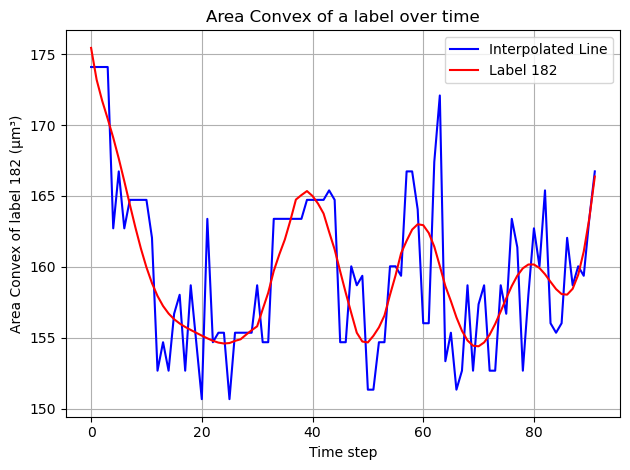

Execution time: 62.351552963256836 secondes


In [4]:
from skimage import io

start_time = time.time()

area_convex_dict = {}

new_area_convex_dict = {}

area_convex_label_dict = {}


fig = go.Figure()

for t in range(image.shape[0]): 
    # Access the data for the current t value
    slices_at_t = image[t, :, :, :]
    properties = regionprops(slices_at_t)
    area_convex_dict[f'area_convex_at_t={t}'] = []
    for prop in properties:
        area_convex_dict[f'area_convex_at_t={t}'].append((prop.label,(prop.area_convex)*voxel_size[0]*voxel_size[1]*voxel_size[2]))
        x,y = zip(*area_convex_dict[f'area_convex_at_t={t}'])
    for i in range(1,num_points+1):
        if i not in x :
            area_convex_dict[f'area_convex_at_t={t}'].insert(i-1,(i,None))
            labels,new_area_convex_dict[f'vol_at_t={t}'] = zip(*area_convex_dict[f'area_convex_at_t={t}'])

# print(new_area_convex_dict[f'vol_at_t={22}'])

for label in range(1,num_points+1) :
    area_convex_label_dict[f'conv_label_{label}'] = []
    for t in range(image.shape[0]):
        area_convex_label_dict[f'conv_label_{label}'].append(new_area_convex_dict[f'vol_at_t={t}'][label-1])

label = 182

# Fill missing values by interpolation
y_interpolated = pd.Series(area_convex_label_dict[f'conv_label_{label}']).interpolate().tolist()

# Plot the graph with interpolated values
plt.plot(range(num_files), y_interpolated, label='Interpolated Line', color="blue")

fin_lin = savgol_filter(y_interpolated,55,10)

plt.plot(range(num_files),fin_lin, label=f'Label {label}', color="red")
plt.xlabel('Time step')
plt.ylabel(f'Area Convex of label {label} (µm³)')
plt.title('Area Convex of a label over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



end_time = time.time()

execution_time = end_time - start_time

print("Execution time:", execution_time, "secondes")

# F - Volume over time 

## Volume of a label over time

(92, 201, 320, 300)


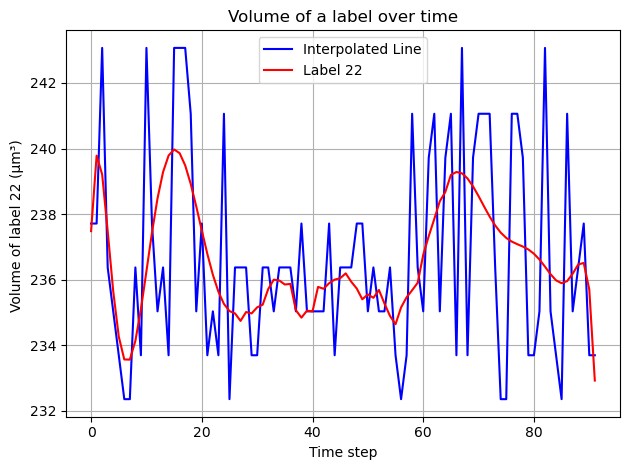

Execution time: 6.416433334350586 secondes


In [5]:
from skimage import io

start_time = time.time()

# Set the default renderer
pio.renderers.default = 'notebook'


# Function to generate a unique random color
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize used colors and random colors
used_colors = set()

volume_px_dict = {}

volume_label_dict = {}

volumes_dict = {}

fig = go.Figure()

print(image.shape)

for t in range(image.shape[0]): 
    # Access the data for the current t value
    slices_at_t = image[t, :, :, :]
    properties = regionprops(slices_at_t)
    volume_px_dict[f'vol_pix_at_t={t}'] = []
    for prop in properties:
        volume_px_dict[f'vol_pix_at_t={t}'].append((prop.label,(prop.area)*voxel_size[0]*voxel_size[1]*voxel_size[2]))
        x,y = zip(*volume_px_dict[f'vol_pix_at_t={t}'])
    for i in range(1,num_points+1):
        if i not in x :
            volume_px_dict[f'vol_pix_at_t={t}'].insert(i-1,(i,None))
            labels,volumes_dict[f'vol_at_t={t}'] = zip(*volume_px_dict[f'vol_pix_at_t={t}'])
#     print(len(volumes_dict[f'vol_at_t={t}']))
            
# print(volumes_dict[f'vol_at_t={91}'] )
            
for label in range(1,num_points+1) :
    volume_label_dict[f'vol_label_{label}'] = []
    for t in range(image.shape[0]):
        volume_label_dict[f'vol_label_{label}'].append(volumes_dict[f'vol_at_t={t}'][label-1])



# Fill missing values by interpolation
y_interpolated = pd.Series(volume_label_dict[f'vol_label_{22}']).interpolate().tolist()

# Plot the graph with interpolated values
plt.plot(range(num_files), y_interpolated, label='Interpolated Line', color="blue")

fin_lin = savgol_filter(y_interpolated,55,10)

plt.plot(range(num_files),fin_lin, label=f'Label {22}', color="red")
plt.xlabel('Time step')
plt.ylabel(f'Volume of label {22} (µm³) ')
plt.title('Volume of a label over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

## Average volume with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole)

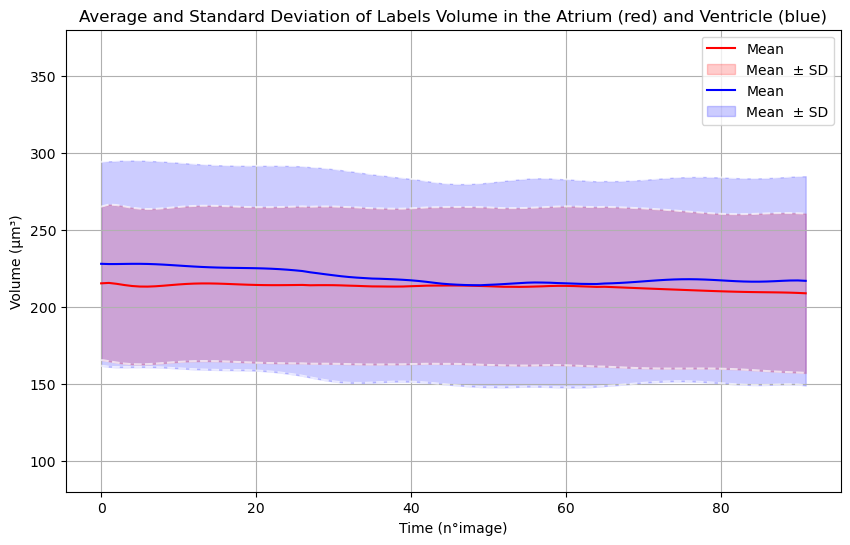

Execution time: 5.784528970718384 secondes


In [5]:
from skimage import io


start_time = time.time()

# Set the default renderer
pio.renderers.default = 'notebook'

# Function to generate a unique random color
def random_color(existing_colors):
    while True:
        color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)'
        if color not in existing_colors:
            existing_colors.add(color)
            return color

# Initialize used colors and random colors
used_colors = set()

volume_px_dict = {}

volume_label_dict = {}

volumes_dict = {}

fig = go.Figure()

for t in range(image.shape[0]): 
    # Access the data for the current t value
    slices_at_t = image[t, :, :, :]
    properties = regionprops(slices_at_t)
    volume_px_dict[f'vol_pix_at_t={t}'] = []
    for prop in properties:
        volume_px_dict[f'vol_pix_at_t={t}'].append((prop.label,(prop.area)*voxel_size[0]*voxel_size[1]*voxel_size[2]))
        x,y = zip(*volume_px_dict[f'vol_pix_at_t={t}'])
    for i in range(1,num_points+1):
        if i not in x :
            volume_px_dict[f'vol_pix_at_t={t}'].insert(i-1,(i,None))
            labels,volumes_dict[f'vol_at_t={t}'] = zip(*volume_px_dict[f'vol_pix_at_t={t}'])
            
# print(volumes_dict[f'vol_at_t={91}'] )
            
for label in range(1,num_points+1) :
    volume_label_dict[f'vol_label_{label}'] = []
    for t in range(image.shape[0]):
        volume_label_dict[f'vol_label_{label}'].append(volumes_dict[f'vol_at_t={t}'][label-1])
    if None in volume_label_dict[f'vol_label_{label}']:
        if label in Atrium :
            Atrium.remove(label)
        if label in Ventricle :
            Ventricle.remove(label)
            
#     print(volume_label_dict[f'vol_label_{label}'])
# Filter valid labels in Atrium
# valid_atrium_labels = [label for label in Atrium if volume_label_dict[f'vol_label_{label}']]

# Check that valid_atrium_labels is not empty
# if not valid_atrium_labels:
#     raise ValueError("No valid volume found in the Atrium.")

# ATRIUM 

mean_volume_in_Atrium = np.mean([volume_label_dict[f'vol_label_{label}'] for label in Atrium], axis=0)
SD_volume_in_Atrium = np.std([volume_label_dict[f'vol_label_{label}'] for label in Atrium], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_volume_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_volume_in_Atrium + SD_volume_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_volume_in_Atrium - SD_volume_in_Atrium,55,10)

# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_volume_in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_volume_in_Atrium + SD_volume_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_volume_in_Atrium - SD_volume_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_volume_in_Atrium)), mean_volume_in_Atrium + SD_volume_in_Atrium, mean_volume_in_Atrium - SD_volume_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_volume_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_volume_in_Ventricle = np.mean([volume_label_dict[f'vol_label_{label}'] for label in Ventricle], axis=0)
SD_volume_in_Ventricle = np.std([volume_label_dict[f'vol_label_{label}'] for label in Ventricle], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_volume_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_volume_in_Ventricle + SD_volume_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_volume_in_Ventricle - SD_volume_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_volume_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_volume_in_Ventricle + SD_volume_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_volume_in_Ventricle - SD_volume_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_volume_in_Ventricle)), mean_volumey_in_Ventricle + SD_volume_in_Atrium, mean_volume_in_Ventricle - SD_volume_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_volume_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# Plot intersection points with annotation
# for idx in sign_changes:
#     plt.plot(idx, smoothing_mean_Ventricle[idx], 'go')  # Mark the intersection point with a green dot
#     plt.annotate(f'({idx}, {smoothing_mean_Ventricle[idx]:.2f})', xy=(idx, smoothing_mean_Ventricle[idx]), xytext=(idx + 5, smoothing_mean_Ventricle[idx] + 0.1),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')


# Configure y-axis limits
plt.ylim(80, 380)

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Volume (µm³)')
plt.title('Average and Standard Deviation of Labels Volume in the Atrium (red) and Ventricle (blue)')
plt.legend()

# Display the plot
plt.show()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

# G - Solidity over time (V/Vconv)

## Solidity of a label over time

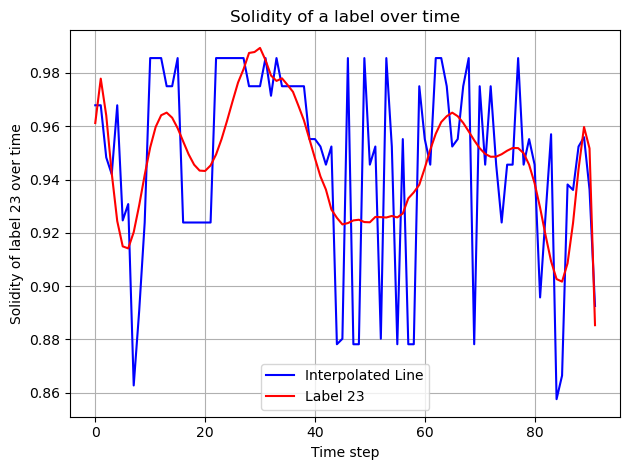

Execution time: 0.15911483764648438 secondes


In [6]:
from skimage import io

start_time = time.time()

solidity_label_dict = {}

# for label in Atrium :
#     print(volume_label_dict[f'vol_label_{label}'])

for label in range(1,num_points+1) :
    solidity_label_dict[f'solidity_label_{label}'] = []
    for t in range(image.shape[0]):
        if volume_label_dict[f'vol_label_{label}'][t] != None :
            solidity_label_dict[f'solidity_label_{label}'].append(volume_label_dict[f'vol_label_{label}'][t]/area_convex_label_dict[f'conv_label_{label}'][t])
        else :
            solidity_label_dict[f'solidity_label_{label}'].append(None)
            

label = 23
# print(area_convex_label_dict[f'conv_label_{label}'])
# print(volume_label_dict[f'vol_label_{label}'])
# print(solidity_label_dict[f'solidity_label_{label}'])

# Fill missing values by interpolation
y_interpolated = pd.Series(solidity_label_dict[f'solidity_label_{label}']).interpolate().tolist()

# Plot the graph with interpolated values
plt.plot(range(num_files), y_interpolated, label='Interpolated Line', color="blue")

fin_lin = savgol_filter(y_interpolated,55,10)

plt.plot(range(num_files),fin_lin, label=f'Label {label}', color="red")
plt.xlabel('Time step')
plt.ylabel(f'Solidity of label {label} over time')
plt.title('Solidity of a label over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

## Average solidity with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole)

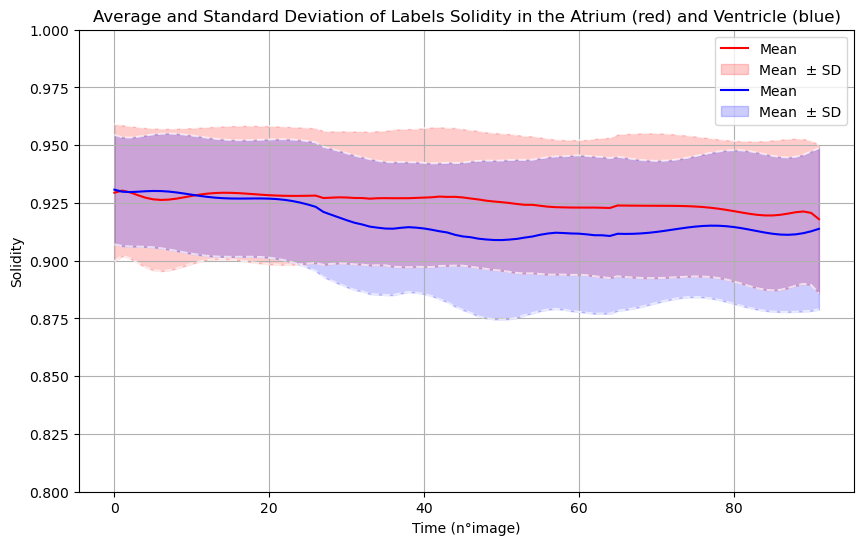

Execution time: 0.2630476951599121 secondes


In [7]:
from skimage import io

start_time = time.time()

solidity_label_dict = {}

for label in range(1,num_points+1) :
    solidity_label_dict[f'solidity_label_{label}'] = []
    for t in range(image.shape[0]):
        if volume_label_dict[f'vol_label_{label}'][t] != None :
            solidity_label_dict[f'solidity_label_{label}'].append(volume_label_dict[f'vol_label_{label}'][t]/area_convex_label_dict[f'conv_label_{label}'][t])
        else :
            solidity_label_dict[f'solidity_label_{label}'].append(None)
            
    if None in solidity_label_dict[f'solidity_label_{label}']:
        if label in Atrium :
            Atrium.remove(label)
        if label in Ventricle :
            Ventricle.remove(label)
            
            
# ATRIUM 

mean_solidity_in_Atrium = np.mean([solidity_label_dict[f'solidity_label_{label}'] for label in Atrium], axis=0)
SD_solidity_in_Atrium = np.std([solidity_label_dict[f'solidity_label_{label}'] for label in Atrium], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_solidity_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_solidity_in_Atrium + SD_solidity_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_solidity_in_Atrium - SD_solidity_in_Atrium,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean__in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_solidity_in_Atrium + SD_solidity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_solidity_in_Atrium - SD_solidity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_solidity_in_Atrium)), mean_solidity_in_Atrium + SD_solidity_in_Atrium, mean_solidity_in_Atrium - SD_solidity_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_solidity_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_solidity_in_Ventricle = np.mean([solidity_label_dict[f'solidity_label_{label}'] for label in Ventricle], axis=0)
SD_solidity_in_Ventricle = np.std([solidity_label_dict[f'solidity_label_{label}'] for label in Ventricle], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_solidity_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_solidity_in_Ventricle + SD_solidity_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_solidity_in_Ventricle - SD_solidity_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_solidity_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_solidity_in_Ventricle + SD_solidity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_solidity_in_Ventricle - SD_solidity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_solidity_in_Ventricle)), mean_solidity_in_Ventricle + SD_solidity_in_Atrium, mean_solidity_in_Ventricle - SD_solidity_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_solidity_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# diff = smoothing_mean_Atrium - smoothing_mean_Ventricle
# sign_changes = np.where(np.diff(np.sign(diff)))[0]

# Plot intersection points with annotation
# for idx in sign_changes:
#     plt.plot(idx, smoothing_mean_Atrium[idx], 'go')  # Mark the intersection point with a green dot
#     plt.annotate(f'({idx}, {smoothing_mean_Atrium[idx]:.2f})', xy=(idx, smoothing_mean_Atrium[idx]), xytext=(idx + 5, smoothing_mean_Atrium[idx] + 0.1),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, ha='left', va='bottom')

# Configure y-axis limits
plt.ylim(0.8, 1)

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Solidity')
plt.title('Average and Standard Deviation of Labels Solidity in the Atrium (red) and Ventricle (blue)')
plt.legend()

# Display the plot
plt.show()

end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

# H - SA:V ratio of the labelled nuclei over time

## Average solidity with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole)

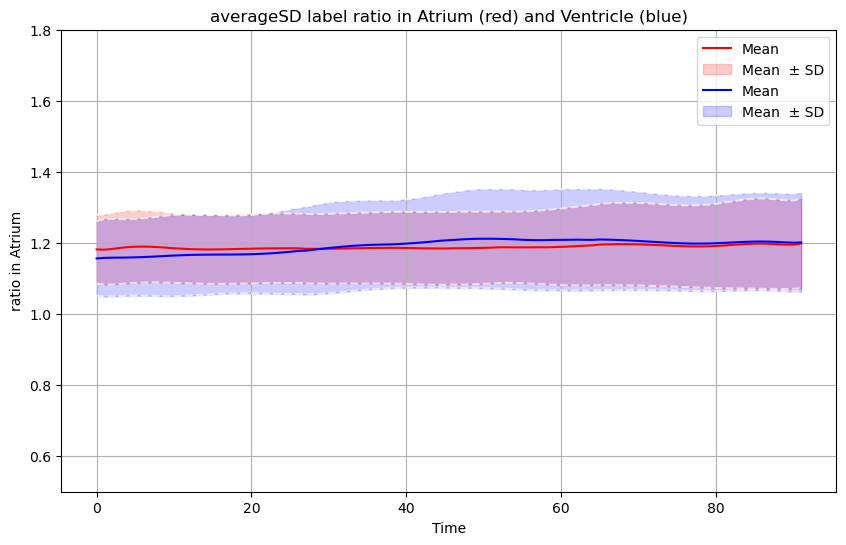

Execution time: 0.17513370513916016 secondes


In [21]:
from skimage import io

start_time = time.time()

ratio_dict = {}


def read_surface_area_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    surface_area_label_dict = {}
    for line in data:
        if ':' in line:
            key, value = line.split(':')
            key = key.strip()
            value = value.strip().strip('[]')
            value_list = []
            for v in value.split(','):
                v = v.strip()
                if v == 'None':
                    value_list.append(None)
                else:
                    value_list.append(float(v))
            surface_area_label_dict[key] = value_list

    return surface_area_label_dict

# Path to the text file
file_path = 'surface_area (SA) LoG.txt'

# Reading and parsing the file
surface_area_label_dict = read_surface_area_file(file_path)

for label in range(1,num_points+1) :
    ratio_dict[f'SA/V_label_{label}'] = []
    for t in range(image.shape[0]):
        if volume_label_dict[f'vol_label_{label}'][t] != None :
            ratio_dict[f'SA/V_label_{label}'].append(surface_area_label_dict[f'SA_label_{label}'][t]/volume_label_dict[f'vol_label_{label}'][t])
        else :
            ratio_dict[f'SA/V_label_{label}'].append(None)
            
    if None in ratio_dict[f'SA/V_label_{label}']:
        if label in Atrium :
            Atrium.remove(label)
        if label in Ventricle :
            Ventricle.remove(label)
        
# ATRIUM 

mean_ratio_in_Atrium = np.mean([ratio_dict[f'SA/V_label_{label}'] for label in Atrium], axis=0)
SD_ratio_in_Atrium = np.std([ratio_dict[f'SA/V_label_{label}'] for label in Atrium], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_ratio_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_ratio_in_Atrium + SD_ratio_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_ratio_in_Atrium - SD_ratio_in_Atrium,55,10)


# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_ratio_in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_ratio_in_Atrium + SD_ratio_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_ratio_in_Atrium - SD_ratio_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_ratio_in_Atrium)), mean_ratio_in_Atrium + SD_ratio_in_Atrium, mean_ratio_in_Atrium - SD_ratio_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_ratio_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE

mean_ratio_in_Ventricle = np.mean([ratio_dict[f'SA/V_label_{label}'] for label in Ventricle], axis=0)
SD_ratio_in_Ventricle = np.std([ratio_dict[f'SA/V_label_{label}'] for label in Ventricle], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_ratio_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_ratio_in_Ventricle + SD_ratio_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_ratio_in_Ventricle - SD_ratio_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_ratio_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_ratio_in_Ventricle + SD_ratio_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_ratio_in_Ventricle - SD_ratio_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_ratio_in_Ventricle)), mean_ratio_in_Ventricle + SD_ratio_in_Atrium, mean_ratio_in_Ventricle - SD_ratio_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_ratio_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

# Configure the labels and legend
plt.xlabel('Time')
plt.ylabel('ratio in Atrium')
plt.title('averageSD label ratio in Atrium (red) and Ventricle (blue)')
plt.legend()

# Configure y-axis limits
plt.ylim(0.5, 1.8)


# Display the plot
plt.show()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

# I - Sphericity over time

## Sphericity of a label over time

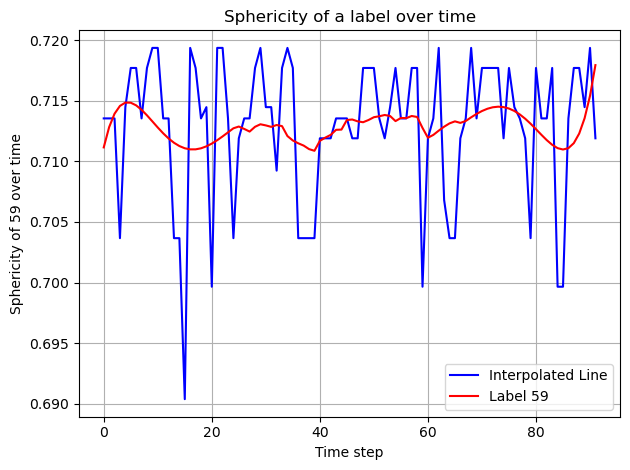

Execution time: 0.1779346466064453 secondes


In [6]:
from skimage import io

start_time = time.time()

def read_surface_area_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    surface_area_label_dict = {}
    for line in data:
        if ':' in line:
            key, value = line.split(':')
            key = key.strip()
            value = value.strip().strip('[]')
            value_list = []
            for v in value.split(','):
                v = v.strip()
                if v == 'None':
                    value_list.append(None)
                else:
                    value_list.append(float(v))
            surface_area_label_dict[key] = value_list

    return surface_area_label_dict

# Path to the text file
file_path = 'surface_area (SA) LoG.txt'

# Reading and parsing the file
surface_area_label_dict = read_surface_area_file(file_path)



sphericity_label_dict = {}

for label in range(1,num_points+1) :
    sphericity_label_dict[f'sphericity_label_{label}'] = []    
    for t in range(image.shape[0]):
#     for t in range(22,25):
        if volume_label_dict[f'vol_label_{label}'][t] != None :
            sphericity_label_dict[f'sphericity_label_{label}'].append((np.pi ** (1 / 3)) * ((6 * volume_label_dict[f'vol_label_{label}'][t]) ** (2 / 3))/surface_area_label_dict[f'SA_label_{label}'][t])
        else :
            sphericity_label_dict[f'sphericity_label_{label}'].append(None)
            

label = 59
# print(surface_area_label_dict[f'SA_label_{label}'])
# print(volume_label_dict[f'vol_label_{label}'])
# print(sphericity_label_dict[f'sphericity_label_{label}'])



# Fill missing values by interpolation
y_interpolated = pd.Series(sphericity_label_dict[f'sphericity_label_{label}']).interpolate().tolist()

# Plot the graph with interpolated values
plt.plot(range(num_files), y_interpolated, label='Interpolated Line', color="blue")

fin_lin = savgol_filter(y_interpolated,50,5)

plt.plot(range(num_files),fin_lin, label=f'Label {label}', color="red")
plt.xlabel('Time step')
plt.ylabel(f'Sphericity of {label} over time')
plt.title('Sphericity of a label over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

## Average sphericity with standard deviation per class (atrium, ventricle) and cardiac phase (diastole, systole)

In [26]:
Atrium.remove(74) # Manually remove labels if they decrease the quality of the result

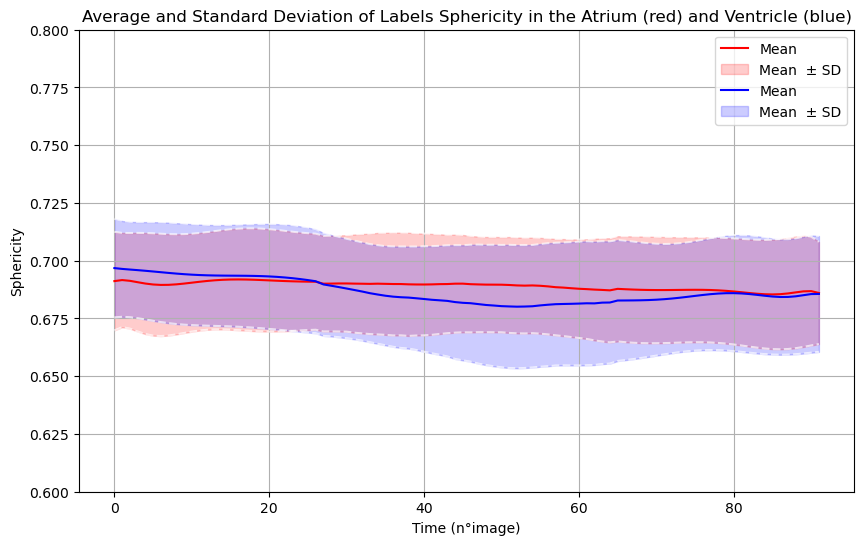

Execution time: 0.19112229347229004 secondes


In [28]:
from skimage import io

start_time = time.time()

def read_surface_area_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    surface_area_label_dict = {}
    for line in data:
        if ':' in line:
            key, value = line.split(':')
            key = key.strip()
            value = value.strip().strip('[]')
            value_list = []
            for v in value.split(','):
                v = v.strip()
                if v == 'None':
                    value_list.append(None)
                else:
                    value_list.append(float(v))
            surface_area_label_dict[key] = value_list

    return surface_area_label_dict

# Path to the text file
file_path = 'surface_area (SA) LoG.txt'

# Reading and parsing the file
surface_area_label_dict = read_surface_area_file(file_path)



sphericity_label_dict = {}

for label in range(1,num_points+1) :
    sphericity_label_dict[f'sphericity_label_{label}'] = []    
    for t in range(image.shape[0]):
        if volume_label_dict[f'vol_label_{label}'][t] != None :
#             if surface_area_label_dict[f'SA_label_{label}'][t] != None :
            sphericity_label_dict[f'sphericity_label_{label}'].append((np.pi ** (1 / 3)) * ((6 * volume_label_dict[f'vol_label_{label}'][t]) ** (2 / 3))/surface_area_label_dict[f'SA_label_{label}'][t])
        else :
            sphericity_label_dict[f'sphericity_label_{label}'].append(None)        
    if None in sphericity_label_dict[f'sphericity_label_{label}']:
        if label in Atrium :
            Atrium.remove(label)
        if label in Ventricle :
            Ventricle.remove(label)
 

# ATRIUM

mean_sphericity_in_Atrium = np.mean([sphericity_label_dict[f'sphericity_label_{label}'] for label in Atrium], axis=0)
SD_sphericity_in_Atrium = np.std([sphericity_label_dict[f'sphericity_label_{label}'] for label in Atrium], axis=0)

smoothing_mean_Atrium = savgol_filter(mean_sphericity_in_Atrium,55,10)
smoothing_mean_plus_SD_Atrium = savgol_filter(mean_sphericity_in_Atrium + SD_sphericity_in_Atrium,55,10)
smoothing_mean_less_SD_Atrium = savgol_filter(mean_sphericity_in_Atrium - SD_sphericity_in_Atrium,55,10)

# mean_sphericity_in_Atrium = np.mean([sphericity_label_dict[f'sphericity_label_{label}'] for label in Atrium], axis=0)

# for label in Atrium:
#     print(len(sphericity_label_dict[f'sphericity_label_{label}']))


# mean_interpolated_in_Atrium = pd.Series(mean_sphericity_in_Atrium).interpolate().tolist()

# SD_sphericity_in_Atrium = np.std([sphericity_label_dict[f'sphericity_label_{label}'] for label in Atrium], axis=0)
# SD_interpolated_in_Atrium = pd.Series(SD_sphericity_in_Atrium).interpolate().tolist()
                              
# smoothing_mean_Atrium = savgol_filter(mean_interpolated_in_Atrium,50,5)
# smoothing_mean_plus_SD_Atrium = savgol_filter(mean_interpolated_in_Atrium + SD_interpolated_in_Atrium,50,5)
# smoothing_mean_less_SD_Atrium = savgol_filter(mean_interpolated_in_Atrium - SD_interpolated_in_Atrium,50,5)

# Create the figure and axes
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the mean
#plt.plot(mean_sphericity_in_Atrium, label='Mean', color='blue')

plt.plot(smoothing_mean_Atrium, label='Mean', color='red')

# Plot the mean + SD
#plt.plot(mean_sphericity_in_Atrium + SD_sphericity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_sphericity_in_Atrium - SD_sphericity_in_Atrium, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Atrium, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_sphericity_in_Atrium)), mean_sphericity_in_Atrium + SD_sphericity_in_Atrium, mean_sphericity_in_Atrium - SD_sphericity_in_Atrium, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_sphericity_in_Atrium)), smoothing_mean_plus_SD_Atrium, smoothing_mean_less_SD_Atrium, color='red', alpha=0.2, label = 'Mean  ± SD')


# VENTRICLE


mean_sphericity_in_Ventricle = np.mean([sphericity_label_dict[f'sphericity_label_{label}'] for label in Ventricle], axis=0)
SD_sphericity_in_Ventricle = np.std([sphericity_label_dict[f'sphericity_label_{label}'] for label in Ventricle], axis=0)

smoothing_mean_Ventricle = savgol_filter(mean_sphericity_in_Ventricle,55,10)
smoothing_mean_plus_SD_Ventricle = savgol_filter(mean_sphericity_in_Ventricle + SD_sphericity_in_Ventricle,55,10)
smoothing_mean_less_SD_Ventricle = savgol_filter(mean_sphericity_in_Ventricle - SD_sphericity_in_Ventricle,55,10)

# Plot the mean
#plt.plot(mean_sphericity_in_Ventricle, label='Mean', color='blue')

plt.plot(smoothing_mean_Ventricle, label='Mean', color='blue')

# Plot the mean + SD
#plt.plot(mean_sphericity_in_Ventricle + SD_sphericity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean + SD')

plt.plot(smoothing_mean_plus_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Plot the mean - SD
#plt.plot(mean_sphericity_in_Ventricle - SD_sphericity_in_Ventricle, linestyle='--', color='blue', alpha=0.7, label='Mean - SD')

plt.plot(smoothing_mean_less_SD_Ventricle, linestyle='--', color='white', alpha=0.7)

# Fill the area between mean + standard deviation and mean - standard deviation
#plt.fill_between(range(len(mean_sphericity_in_Ventricle)), mean_sphericity_in_Ventricle + SD_sphericity_in_Atrium, mean_sphericity_in_Ventricle - SD_sphericity_in_Ventricle, color='blue', alpha=0.2)

plt.fill_between(range(len(mean_sphericity_in_Ventricle)), smoothing_mean_plus_SD_Ventricle, smoothing_mean_less_SD_Ventricle, color='blue', alpha=0.2, label = 'Mean  ± SD')

plt.ylim(0.60, 0.8)

# Configure the labels and legend
plt.xlabel('Time (n°image)')
plt.ylabel('Sphericity')
plt.title('Average and Standard Deviation of Labels Sphericity in the Atrium (red) and Ventricle (blue)')
plt.legend()

# Display the plot
plt.show()


end_time = time.time()


execution_time = end_time - start_time
print("Execution time:", execution_time, "secondes")

In [31]:
Atrium.append(74)